# Experiment

### Detailed Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import math
import os
import pickle

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)

NUM_LOGS = 101876733

NUM_REGEX = 132
NUM_REP = 1

ns = [4, 8, 16, 32, 64, 96, 128, 192, 256, 320, 384, 448, 512]
grams_fp = ['bi-gram']
grams_fp_header = ['bigram', 'trigram', 'fourgram',]

INDEX_HEADERS = ['NGram', 'Num_Indexed', 'bitvector_index_building_time', 'bitvector_index_size', 'inverted_index_building_time', 'inverted_index_size_fit', 'inverted_index_size']

edgecolor_run = '#0173b2'
colors_run = list(reversed(['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']))

colors_idx = list(reversed(['#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#b30000', '#7f0000']))
edgecolor_idx = '#d55e00'

colors_log = list(reversed(['#f7fcfd', '#e0ecf4', '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1' ,'#88419d', '#810f7c', '#4d004b']))
edgecolor_log = '#821580'

DIR_NAME = 'out_8_full_combined'


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
blare_times = pd.read_pickle('../blare_sqlserver_full.pkl')

In [4]:
# index building time
bt_df = pd.read_csv(f'{DIR_NAME}/index_building.csv', names=INDEX_HEADERS)  
bt_df['bitvector_index_size'] = bt_df['bitvector_index_size']/(1024 * 1024  * 1024)
bt_df['inverted_index_size'] = bt_df['inverted_index_size']/(1024 * 1024 * 1024)
bt_df['inverted_index_size_fit'] = bt_df['inverted_index_size_fit']/(1024 * 1024 * 1024)

In [5]:
bt_df[bt_df['NGram']=='bigram']

,NGram,Num_Indexed,bitvector_index_building_time,bitvector_index_size,inverted_index_building_time,inverted_index_size_fit,inverted_index_size
0,bigram,64,511.584,0.759041,573.147,6.949716,1.431656e+09
3,bigram,4,445.201,0.759041,531.439,0.678750,1.431656e+09
4,bigram,8,450.849,0.759041,555.835,1.234455,1.431656e+09
5,bigram,16,459.551,0.759041,559.067,2.236086,1.431656e+09
6,bigram,32,480.645,0.759041,644.843,4.074073,1.431656e+09
7,bigram,64,511.869,0.759041,572.950,6.949716,1.431656e+09
8,bigram,96,550.170,1.518082,596.179,8.555917,1.431656e+09
9,bigram,128,539.961,1.518082,572.769,10.095716,1.431656e+09
10,bigram,192,564.428,2.277122,600.318,12.951478,1.431656e+09
11,bigram,256,591.265,3.036163,639.640,14.712529,1.431656e+09


In [6]:
bt_df = bt_df[bt_df['NGram'] == 'bigram']

In [7]:
def get_num_bits_masked(df, inverted):
    bit_masks = df['filter'].to_list()
    total_count = 0
    for m in bit_masks:
        if inverted:
            total_count += m.count('0')
        else:
            total_count += m.count('1')
    return total_count

In [8]:
fingerprint = 'bigram'

partial_df = bt_df[bt_df['NGram'] == fingerprint]
line_remains, ave_perc_line_rem, bits_masked = [], [], []
bit_bt_mean, bit_bt_se = [], []
inv_bt_mean, inv_bt_se = [], []
bt_size, inv_size = [], []
ft_mean, ft_se, total_matched = [], [], []
inv_mean, inv_se = [], []
blare_mean, blare_se = [], []

for num_indexed in ns:
    # for a q-gram signature, with n qgrams indexed,

    bit_bt_times = partial_df[partial_df['Num_Indexed'] == num_indexed]['bitvector_index_building_time']
    inv_bt_times = partial_df[partial_df['Num_Indexed'] == num_indexed]['inverted_index_building_time']

    bt_sizes = partial_df[partial_df['Num_Indexed'] == num_indexed]['bitvector_index_size']
    inv_sizes = partial_df[partial_df['Num_Indexed'] == num_indexed]['inverted_index_size']

    bit_bt_mean.append(np.mean(bit_bt_times))
    inv_bt_mean.append(np.mean(inv_bt_times))

    bt_size.append(np.mean(bt_sizes))
    inv_size.append(np.mean(inv_sizes))

    bit_bt_se.append(np.std(bit_bt_times, ddof=1)/np.sqrt(len(bit_bt_times)))
    inv_bt_se.append(np.std(inv_bt_times, ddof=1)/np.sqrt(len(inv_bt_times)))

    filter_times = []
    invert_times = []
    dir_name = f'{DIR_NAME}/new_{fingerprint}_{num_indexed}'

    # Summary csv
    f_name = os.path.join(dir_name, 'summary0.csv')
    sum_df = pd.read_csv(f_name, sep='\t', dtype={'filter': str})

    line_rem_total = sum_df['num_after_filter'].sum()
    line_remains.append(line_rem_total)
    ave_perc_line_rem.append(100*line_rem_total/(NUM_LOGS*NUM_REGEX))

    bits_masked.append(get_num_bits_masked(sum_df, inverted=True))
    curr_filter_matched = sum_df['match_num_filter'].sum()
    curr_invert_matched = sum_df['match_num_inverted'].sum()
    assert(curr_filter_matched == curr_invert_matched)
    total_matched.append(curr_filter_matched)

    # list of all experiments       
    for subf in os.listdir(dir_name):
        if fingerprint in subf:
            f_name = os.path.join(dir_name, subf)
            df = pd.read_csv(f_name, sep='\t')
            filter_times.append(df['filter_time'].sum())
            invert_times.append(df['inverted_time'].sum())
    if len(filter_times) >= 3:
            filter_times = sorted(filter_times)[1:-1]
            invert_times = sorted(invert_times)[1:-1]
    ft_mean.append(np.mean(filter_times))
    ft_se.append(np.std(filter_times, ddof=1)/np.sqrt(len(filter_times)))
    inv_mean.append(np.mean(invert_times))
    inv_se.append(np.std(invert_times, ddof=1)/np.sqrt(len(invert_times)))

df = pd.DataFrame(list(zip(ns, line_remains, ave_perc_line_rem, bits_masked, 
                           bit_bt_mean, bit_bt_se,
                           inv_bt_mean, inv_bt_se,
                           bt_size, inv_size,
                           ft_mean, ft_se, 
                           inv_mean, inv_se,
                           total_matched)), 
                 columns=['Num_Indexed', 'Log_After_Filter', 'Ave_Perc_Log_After_Filter', 'Num_Bits_Masked', 
                        'Bit_Index_Building_Time_Mean(s)', 'Bit_Index_Building_Time_SE(s)',
                        'Inverted_Index_Building_Time_Mean(s)', 'Inverted_Index_Building_Time_SE(s)',
                        'Bit_Index_Size(MB)', 'Inverted_Index_Size(MB)',
                        'Bitvec_Time_Mean(s)', 'Bitvec_Time_SE(s)', 
                        'Inverted_Time_Mean(s)', 'Inverted_Time_SE(s)', 
                        'Num_Matched'])

# with open('../blare_sqlserver_full.pkl', 'wb') as f:
#     pickle.dump(blare_times, f)

blare_times = sorted(blare_times)[1:-1]
blare_mean.append(np.mean(blare_times))
blare_se.append(np.std(blare_times, ddof=1)/np.sqrt(len(blare_times)))

In [ ]:
df['Log_After_Filter2'] = 100*df['Log_After_Filter']/(NUM_LOGS*NUM_REGEX)

In [14]:
'''
plot_dict: {
    col: [column name for plotting in df],
    ylabel: [y label],
}
'''
def plot_bar(df, plot_dict, color_map, edge_color, fname_prefix, log_scale=False):
    fig, ax = plt.subplots(figsize=(9.6,3.6))
    plt.grid(axis='y')
    
    x = np.arange(len(ns))
    
    gram = 'Bigram'

    rects = ax.bar(x, df[plot_dict['col']], color=color_map, edgecolor=edge_color, label=gram)
    ax.set_xticks(x , ns)
    
    ax.bar_label(ax.containers[0], fmt='%.2f')

    maxy = 1.2*np.max(df[plot_dict['col']].to_list())
    if log_scale:
        plt.yscale('log')
        plt.ylim( (pow(10,-1),pow(10,np.log10(maxy))) )
    else:
        plt.ylim(0, maxy)

    print([p.get_width() for p in ax.patches])

    plt.xlabel(f'Number of Bigrams Indexed')
    plt.ylabel(plot_dict['ylabel'])
    log_scale_tag = '' if not log_scale else '_log'
    plt.savefig(f'figs/Bigram_{fname_prefix}_bar{log_scale_tag}.pdf', bbox_inches = 'tight')
    plt.show()

[0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]


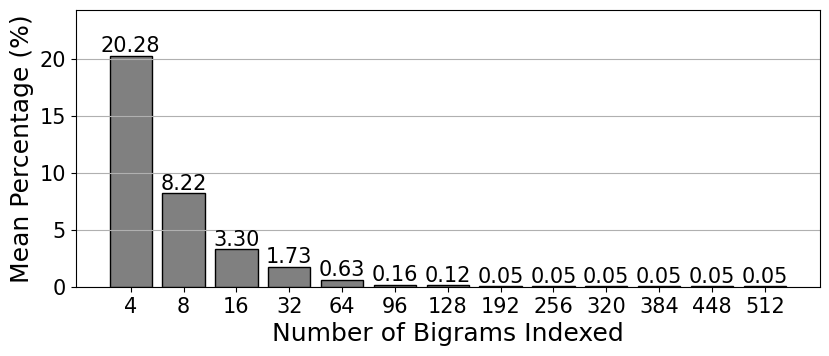

In [15]:
plot_dict= {
    'col': 'Ave_Perc_Log_After_Filter',
    'ylabel': 'Mean Percentage (%)',
    'title': 'Mean Percentage of Logs Remaining After Filter Per Regex'
}
plot_bar(df, plot_dict, 'grey', 'black', fname_prefix='AvePercAfterFilter')

In [16]:
def plot_bar_with_err(df, plot_dict, color_map, edge_color, fname_prefix, log_scale=False, baseline=False):
    fig, ax = plt.subplots(figsize=(9.6,3.6))
    plt.grid(axis='y')

    x = np.arange(len(ns))  # the label locations

    gram = 'Bigram Index'
    
    if baseline:
        y_est = [blare_mean[0]] * len(x)
        y_err = [blare_se[0]] * len(x)    
        width = df.shape[0]  # the width of the bars
        rects = ax.bar([x[0]+0.46*width], [blare_mean[0]], width+0.5 , color='gray', label='BLARE-RE2', alpha=0.2)
    
    rects = ax.bar(x, df[plot_dict['col_y']], yerr=None if plot_dict['col_err'] is None else df[plot_dict['col_err']], color=color_map, edgecolor=edge_color, label=gram)

    ax.set_xticks(x, ns)

    for c in ax.containers[0::2]:
        ax.bar_label(c, fmt='%.0f')
    
    maxy = 1.2*np.max(df[plot_dict['col_y']].to_list())
    if baseline:
        maxy = 1.1*np.max([blare_mean[0],maxy])
    if log_scale:
        plt.yscale('log')
        plt.ylim( (pow(10,-1),pow(10,np.log10(maxy))) )
    else:
        if 'Building' in plot_dict['title']:
            miny = 0.8*np.min(df[plot_dict['col_y']].to_list())
            plt.ylim(miny, maxy*0.9)
        else:
            plt.ylim(0, maxy)
            
    print([p.get_width() for p in ax.patches])
    
    plt.xlabel(f'Number of Bigrams Indexed')
    plt.ylabel(plot_dict['ylabel'])

    if baseline:
        plt.legend(loc='best')
    log_scale_tag = '' if not log_scale else '_log'

    plt.savefig(f'figs/Bigram_{fname_prefix}_errbar_{log_scale_tag}.pdf', bbox_inches = 'tight')

    plt.show()

[0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]


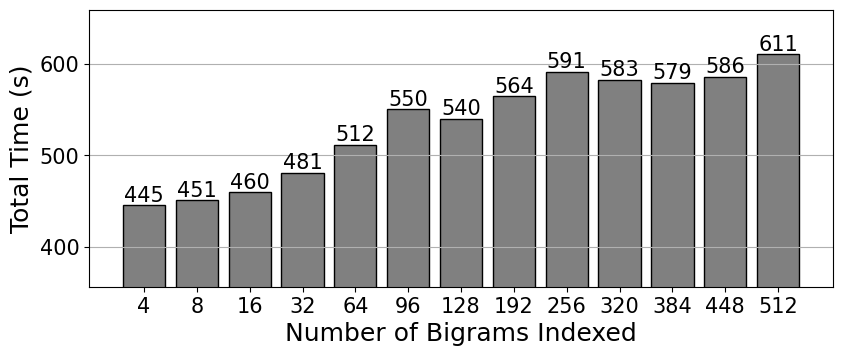

In [17]:
plot_dict= {
    'col_y': 'Bit_Index_Building_Time_Mean(s)',
    'col_err': None, #'Bit_Index_Building_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': 'Bigram Index Building Time'
}
plot_bar_with_err(df, plot_dict, 'grey', 'black', fname_prefix='IndexBuilding', log_scale=False, baseline=False)

[13.5, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]


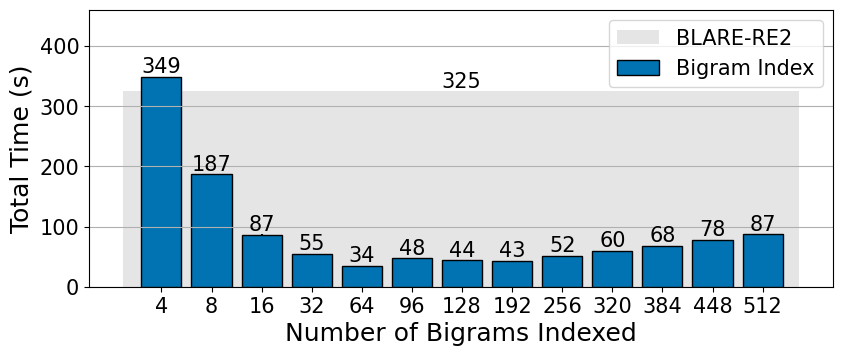

In [18]:
plot_dict= {
    'col_y': 'Bitvec_Time_Mean(s)',
    'col_err': 'Bitvec_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': 'Bigram Filter Runtime'
}


plot_bar_with_err(df, plot_dict, '#0173b2', 'black', fname_prefix='SearchTime', log_scale=False, baseline=True)